### [64 注意力机制](https://www.bilibili.com/video/BV1264y1i7R1?spm_id_from=333.999.0.0&vd_source=1d3a7b81d826789081d8b6870d4fff8e)



- 卷积、全连接、池化层都只考虑不随意线索（没有明确的目标）

  - 池化操作通常是将感受野范围中的最大值提取出来（最大池化）
卷积操作通常是对输入全部通过卷积核进行操作，然后提取出一些比较明显的特征




- 注意力机制是显式地考虑随意线索

  - 随意线索被称之为查询（query）---- 所想要做的事情
每个输入是一个值（value）和不随意线索（key）的对 ---- 可以理解为环境，就是一些键值对，key 和 value 可以相同，也可以不同
  - 通过注意力池化层来有偏向性地选择某些输入 ---- 根据 query 有偏向地选择输入，跟之前的池化层有所不同，这里显式地加入了 query，然后根据 query 查询所需要的东西

<img src="picture/屏幕截图 2022-06-20 232907.png">

- 非参：不需要学习参数
- xy为输入数据对 x -- key/y -- value
- f（x）-- 对应所要查询的东西
- （x，y） -- key-value对（候选）
- 平均池化：之所以是最简单的方案，是因为不需要管所查询的东西（也就是f（x）中的 x ），而只需要无脑地对 y 求和取平均就可以了
- K是核函数，见附录10
- 这个函数使得f(x)倾向于选择和x较为接近的xi

1. $$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
2. $$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$
3. $$\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}$$

- 如果我们选择高斯核函数的话，因为恰好有$e^x$项存在，所以可以转换为softmax形式
- 这个时候可以看出没有需要学习的参数，统计学派倾向于没有参数，但作为调参侠，这是不可接受的！
- 那么我们就加上一个参数好了

<img src="picture/屏幕截图 2022-06-21 003933.png">

- 需要说明的是这只是一种方式，还有很多种
- 为什么w加在这，这里不谈数学，w主要控制的是曲线的平滑度，这个可以在后面看出

In [45]:
import torch
from torch import nn
from d2l import torch as d2l

我们创建一个带有噪声的非线性函数 $y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon$

In [46]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [47]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

我们先使用最简单的估计器来解决回归问题： 基于平均汇聚来计算所有训练样本输出值的平均值：$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

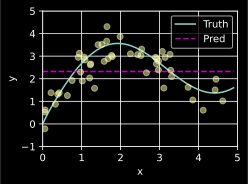

In [48]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test) # 这个函数和之前的repeat差不多
plot_kernel_reg(y_hat)

不带参数注意力汇聚

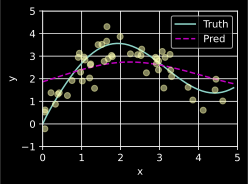

In [49]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

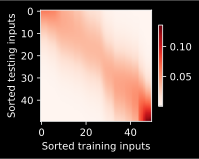

In [50]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

$$\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}$$

假设第一个小批量数据包含个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$， 形状为$a\times b$， 第二个小批量包含个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$， 形状为$b\times c$。 它们的批量矩阵乘法得到个矩阵$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ ， 形状为$a\times c$。 因此，假定两个张量的形状分别是(n,a,b)和(n,b,c)， 它们的批量矩阵乘法输出的形状为(n,a,c)。

In [51]:
# 2是批量大小
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [52]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

带参数的注意力汇聚，使用小批量矩阵乘法， 定义Nadaraya-Watson核回归的带参数版本为：

In [53]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

接下来，将训练数据集变换为键和值用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [54]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

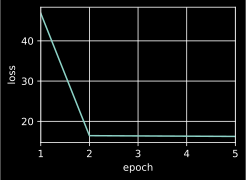

In [55]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

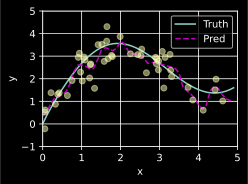

In [56]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

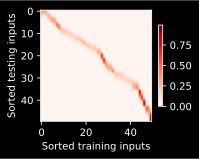

In [57]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

- Nadaraya-Watson核回归是具有注意力机制的机器学习范例。

- Nadaraya-Watson核回归的注意力汇聚是对训练数据中输出的加权平均。从注意力的角度来看，分配给每个值的注意力权重取决于将值所对应的键和查询作为输入的函数。

- 注意力汇聚可以分为非参数型和带参数型。